In [1]:
import tensorflow as tf
from time import time
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import mlutils, pickle, bz2
%matplotlib inline

## Observe AlexNet filters for the first two convolutional layers

Pretrained Network: https://www.cs.toronto.edu/~guerzhoy/tf_alexnet/

Paper: [ImageNet Classification with Deep Convolutional Neural Networks](https://papers.nips.cc/paper/4824-imagenet-classification-with-deep-convolutional-neural-networks.pdf)

Source images: [Large Scale Visual Recognition Challenge 2012](http://www.image-net.org/challenges/LSVRC/2012/) [ImageNet](http://www.image-net.org)

Local file with weights from first two layers only



In [5]:
!ls -lash data/alexnet_conv1_conv2.pklz

1.4M -rw-r--r-- 1 user root 1.4M Jun  5 19:18 data/alexnet_conv1_conv2.pklz


In [6]:
alex_c12 = pickle.load(bz2.BZ2File("data/alexnet_conv1_conv2.pklz", "r"), encoding="bytes")
for k,(w,b) in alex_c12.items():
    print(k, b.shape, w.shape)

b'conv2' (256,) (5, 5, 48, 256)
b'conv1' (96,) (11, 11, 3, 96)


we use for the moment only the first layer

(11, 11, 3, 96)


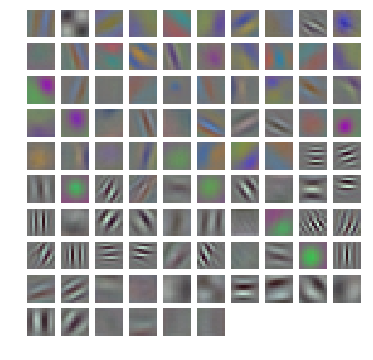

In [10]:
alex_w1 = alex_c12[b"conv1"][0]
print(alex_w1.shape)
mlutils.display_imgs(alex_w1)

### Vamos a usarlos como punto de partida para el entrenamiento de nuestra red

In [11]:
!wget -nc https://s3.amazonaws.com/rlx/mini_cifar.h5

File ‘mini_cifar.h5’ already there; not retrieving.



In [12]:
import h5py
with h5py.File('mini_cifar.h5','r') as h5f:
    x_cifar = h5f["x"][:]
    y_cifar = h5f["y"][:]

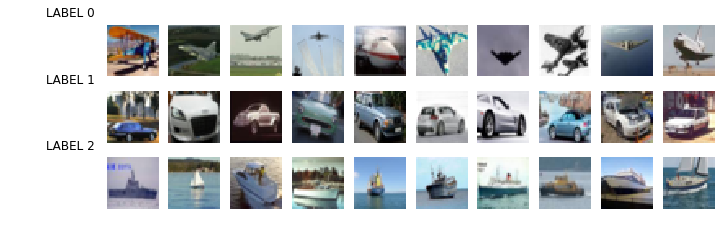

In [13]:
mlutils.show_labeled_image_mosaic(x_cifar, y_cifar)

In [14]:
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(x_cifar, y_cifar, test_size=.25)
print(x_train.shape, y_train.shape, x_test.shape, y_test.shape)
print("\ndistribution of train classes")
print(pd.Series(y_train).value_counts())
print("\ndistribution of test classes")
print(pd.Series(y_test).value_counts())

(2253, 32, 32, 3) (2253,) (751, 32, 32, 3) (751,)

distribution of train classes
2    769
0    764
1    720
dtype: int64

distribution of test classes
2    256
1    254
0    241
dtype: int64


In [15]:
def get_conv_model_C(num_classes, img_size=32, compile=True):
    tf.reset_default_graph()
    tf.keras.backend.clear_session()
    print("using",num_classes,"classes")
    inputs = tf.keras.Input(shape=(img_size,img_size,3), name="input_1")
    layers = tf.keras.layers.Conv2D(96,(11,11), activation="relu")(inputs)
    layers = tf.keras.layers.MaxPool2D((2,2))(layers)
    layers = tf.keras.layers.Conv2D(60,(11,11), activation="relu")(layers)
    layers = tf.keras.layers.Flatten()(layers)
    layers = tf.keras.layers.Dropout(0.4)(layers)
    layers = tf.keras.layers.Dense(16, activation=tf.nn.relu)(layers)
    layers = tf.keras.layers.Dropout(0.4)(layers)
    predictions = tf.keras.layers.Dense(num_classes, activation=tf.nn.softmax, name="output_1")(layers)
    model = tf.keras.Model(inputs = inputs, outputs=predictions)
    if compile:
        model.compile(optimizer='adam',
                      loss='sparse_categorical_crossentropy',
                      metrics=['accuracy'])
    return model

In [16]:
def train(model, batch_size, epochs, model_name=""):
    tensorboard = tf.keras.callbacks.TensorBoard(log_dir="logs/"+model_name+"_"+"{}".format(time()))
    model.reset_states()
    model.fit(x_train, y_train, epochs=epochs, callbacks=[tensorboard],
              batch_size=batch_size,
              validation_data=(x_test, y_test))
    metrics = model.evaluate(x_test, y_test)
    return {k:v for k,v in zip (model.metrics_names, metrics)}

In [17]:
num_classes = len(np.unique(y_cifar))
model = get_conv_model_C(num_classes)
model.summary()

using 3 classes
Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 32, 32, 3)         0         
_________________________________________________________________
conv2d (Conv2D)              (None, 22, 22, 96)        34944     
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 11, 11, 96)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 1, 1, 60)          697020    
_________________________________________________________________
flatten (Flatten)            (None, 60)                0         
_________________________________________________________________
dropo

## Transfer learning!!!

- Importamos el valor de los filtros de primer nivel


In [18]:
w = model.get_weights()
for i in w:
    print(i.shape)

(11, 11, 3, 96)
(96,)
(11, 11, 96, 60)
(60,)
(60, 16)
(16,)
(16, 3)
(3,)


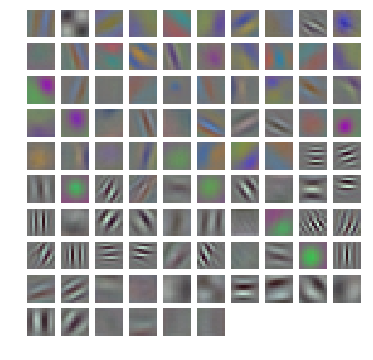

In [19]:
w[0] = alex_w1
mlutils.display_imgs(w[0])

In [20]:
model.set_weights(w)

In [21]:
train(model, batch_size=16, epochs=15, model_name="alexnet_fintuned")

Train on 2253 samples, validate on 751 samples
Epoch 1/15
2253/2253 [==============================] - 12s 5ms/sample - loss: 1.0775 - acc: 0.4301 - val_loss: 0.9151 - val_acc: 0.5992
Epoch 2/15
2253/2253 [==============================] - 10s 4ms/sample - loss: 0.9452 - acc: 0.5344 - val_loss: 0.8098 - val_acc: 0.6338
Epoch 3/15
2253/2253 [==============================] - 10s 4ms/sample - loss: 0.8683 - acc: 0.5655 - val_loss: 0.7873 - val_acc: 0.6258
Epoch 4/15
2253/2253 [==============================] - 16s 7ms/sample - loss: 0.8245 - acc: 0.6170 - val_loss: 0.7548 - val_acc: 0.6498
Epoch 5/15
2253/2253 [==============================] - 17s 8ms/sample - loss: 0.7739 - acc: 0.6405 - val_loss: 0.7250 - val_acc: 0.6618
Epoch 6/15
2253/2253 [==============================] - 18s 8ms/sample - loss: 0.7425 - acc: 0.6534 - val_loss: 0.7231 - val_acc: 0.6831
Epoch 7/15
2253/2253 [==============================] - 17s 8ms/sample - loss: 0.7274 - acc: 0.6822 - val_loss: 0.6837 - val_acc: 0

{'loss': 0.6857326014857794, 'acc': 0.7336884}

Normalized confusion matrix
[[0.78008299 0.07053942 0.14937759]
 [0.08661417 0.77952756 0.13385827]
 [0.296875   0.05859375 0.64453125]]


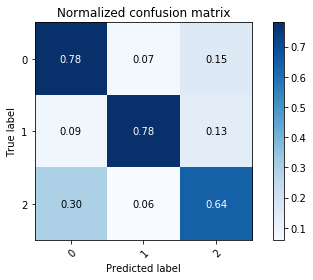

In [22]:
test_preds = model.predict(x_test).argmax(axis=1)
mlutils.plot_confusion_matrix(y_test, test_preds, classes=np.r_[0,1,2], normalize=True)

observa que los filtros de primer nivel cambiaron, pero muy poco

In [23]:
w0 = model.get_weights()[0]
np.mean(np.abs(w0-alex_w1))

0.02134593

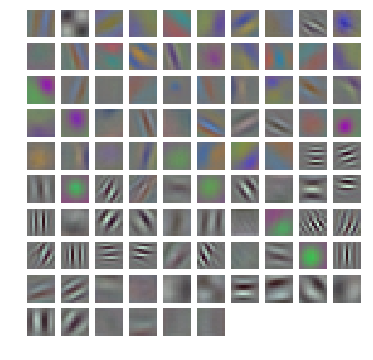

In [24]:
mlutils.display_imgs(w[0])

In [25]:
model.save("alexnet_finetuned_minicifar.model")

observe that you can also save separately the architecture

In [26]:
with open('alexnet_finetuned_minicifar.architecture.json', 'w') as f:
    f.write(model.to_json())

In [27]:
!ls -lash alexnet_finetuned_minicifar*

8.0K -rw-r--r-- 1 user root 3.6K Jun  5 20:49 alexnet_finetuned_minicifar.architecture.json
8.5M -rw-r--r-- 1 user root 8.5M Jun  5 20:49 alexnet_finetuned_minicifar.model


In [28]:
!head alexnet_finetuned_minicifar.architecture.json

{"class_name": "Model", "config": {"name": "model", "layers": [{"name": "input_1", "class_name": "InputLayer", "config": {"batch_input_shape": [null, 32, 32, 3], "dtype": "float32", "sparse": false, "name": "input_1"}, "inbound_nodes": []}, {"name": "conv2d", "class_name": "Conv2D", "config": {"name": "conv2d", "trainable": true, "dtype": "float32", "filters": 96, "kernel_size": [11, 11], "strides": [1, 1], "padding": "valid", "data_format": "channels_last", "dilation_rate": [1, 1], "activation": "relu", "use_bias": true, "kernel_initializer": {"class_name": "GlorotUniform", "config": {"seed": null, "dtype": "float32"}}, "bias_initializer": {"class_name": "Zeros", "config": {"dtype": "float32"}}, "kernel_regularizer": null, "bias_regularizer": null, "activity_regularizer": null, "kernel_constraint": null, "bias_constraint": null}, "inbound_nodes": [[["input_1", 0, 0, {}]]]}, {"name": "max_pooling2d", "class_name": "MaxPooling2D", "config": {"name": "max_pooling2d", "trainable": true, "